In [1]:
import os
os.chdir("/home/ec2-user/scVI/")

In [42]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
n_layer_decoder = 2
n_latent = 10
scale_adversarial = 0

In [4]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir, assign_label
import numpy as np
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.harmonization.utils_chenling import eval_latent, run_model, SubsetGenes
from copy import deepcopy
from scvi.inference import UnsupervisedTrainer, AdversarialTrainerVAE
from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scvi.models.vae import VAE
from sklearn.neighbors import NearestNeighbors
from scvi.dataset import GeneExpressionDataset, Dataset10X, CiteSeqDataset

use_cuda = True

from scvi.dataset.muris_tabula import TabulaMuris
dataset1 = TabulaMuris('facs')
dataset2 = TabulaMuris('droplet')
dataset1.subsample_genes(dataset1.nb_genes)
dataset2.subsample_genes(dataset2.nb_genes)

gene_dataset = GeneExpressionDataset.concat_datasets(dataset1, dataset2)
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset, "Tech1")

True
Downsampling from 20508 to 17802 genes
Downsampling from 5351 to 5351 cells
Downsampling from 20508 to 14687 genes
Downsampling from 4112 to 4112 cells
Keeping 14590 genes
Downsampling from 17802 to 1804 genes
Downsampling from 5351 to 5351 cells
Downsampling from 14687 to 1804 genes
Downsampling from 4112 to 4112 cells
Downsampling from 14590 to 1804 genes
Downsampling from 9463 to 9463 cells


In [5]:
def compute_stats(n_layer_decoder=2, n_latent=10, scale_adversarial=0):
    vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=n_latent, n_layers=2, n_layers_decoder=n_layer_decoder, dispersion='gene')
    # trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
    trainer = AdversarialTrainerVAE(vae, gene_dataset, train_size=1.0, scale=scale_adversarial)
    trainer.train(n_epochs=200)
    full = trainer.create_posterior(vae, gene_dataset, indices=np.arange(len(gene_dataset)))
    ll = full.ll(verbose=True)
    latent, batch_indices, labels = full.sequential().get_latent()

    batch_indices = batch_indices.ravel()
    labels = labels.ravel()
    res = clustering_scores(latent, labels, 'knn')
    res["batch_entropy"] = trainer.train_set.entropy_batch_mixing()
    res["ll"] = ll

    return[n_layer_decoder, n_latent, scale_adversarial, res["asw"], res["ca"], res["weighted ca"], res["batch_entropy"], res["ll"]]


In [35]:
# layer_experiment = []
# for n_layer_decoder in np.repeat(np.array([1, 2, 3, 4]), 5):
#     layer_experiment.append(compute_stats(n_layer_decoder=n_layer_decoder))
    
# latent_experiment = []
# for n_latent in np.repeat(np.array([5, 10, 20, 30, 50]), 5):
#     latent_experiment.append(compute_stats(n_latent=n_latent))

# adver_experiment = []
# for scale_adversarial in np.repeat(np.array([0, 0.1, 1, 10, 100]), 5):
#      adver_experiment.append(compute_stats(scale_adversarial=float(scale_adversarial)))
    
layer_experiment = np.array(
    [[1, 10, 0, 0.15525919, 0.9432526682870126, 0.8722377321902276, 0.227360496008613, 2453.7534047078093], 
     [1, 10, 0, 0.15215963, 0.9476910070802071, 0.8865628802057167, 0.21025245890275585, 2369.072740542111], 
     [1, 10, 0, 0.16742632, 0.9470569586811793, 0.8848708566773789, 0.21903153691538182, 2370.32746288175], 
     [1, 10, 0, 0.15581578, 0.9426186198879848, 0.8767259380104789, 0.22115996923289205, 2378.860856097432], 
     [1, 10, 0, 0.13869151, 0.9487477544119202, 0.885819922635195, 0.17891493524216337, 2352.19849017225], 
     [2, 10, 0, 0.1291283, 0.9432526682870126, 0.881940038576043, 0.24813407790262818, 2352.692805201839], 
     [2, 10, 0, 0.13037115, 0.9423015956884709, 0.8760906899617613, 0.25788447218025196, 2347.754580339216], 
     [2, 10, 0, 0.12495365, 0.9448377892845821, 0.8838103998372119, 0.23293382285384925, 2351.628658987636], 
     [2, 10, 0, 0.12804654, 0.9418788967557857, 0.8829268101726848, 0.26775867342834714, 2353.8560445947373], 
     [2, 10, 0, 0.1406937, 0.9462115608158089, 0.8950253419197621, 0.23860294053351971, 2350.713997939343], 
     [3, 10, 0, 0.11721466, 0.9368065095635634, 0.8811021663669865, 0.2967830005980863, 2354.9662947136217], 
     [3, 10, 0, 0.11874062, 0.9418788967557857, 0.884301633760097, 0.262314807832848, 2352.4101533604567], 
     [3, 10, 0, 0.12385929, 0.9450491387509247, 0.889236593335654, 0.26980954994238343, 2350.619881380112], 
     [3, 10, 0, 0.1238305, 0.9371235337630772, 0.8750341802527997, 0.2750601656837278, 2348.4493553841276], 
     [3, 10, 0, 0.123585984, 0.9406107999577301, 0.867433340792433, 0.2904036544670669, 2366.065917917151], 
     [4, 10, 0, 0.12732863, 0.9374405579625912, 0.8713883416371276, 0.3017456628560973, 2356.892424772799], 
     [4, 10, 0, 0.114811055, 0.9391313536933319, 0.8735686296536865, 0.27105522360349693, 2375.69566172197],
     [4, 10, 0, 0.12040063, 0.9386029800274754, 0.8763373386780604, 0.3214244254261754, 2417.9153776550775],
     [4, 10, 0, 0.14341849, 0.9379689316284476, 0.8805875810984961, 0.2757601504240046, 2365.0355529430412],
     [4, 10, 0, 0.13126518, 0.9386029800274754, 0.8701494987183424, 0.2832192691177277, 2359.343218323999]])

latent_experiment = np.array(
    [[2, 5, 0, 0.12981378, 0.9331078939025679, 0.8649162259774879, 0.27710092704011924, 2373.327451323576], 
     [2, 5, 0, 0.17664295, 0.9303603508401141, 0.8576976258731115, 0.3231586974845402, 2379.891336653281], 
     [2, 5, 0, 0.15004794, 0.9330022191693966, 0.8816293247735697, 0.28602989541029256, 2357.182236077354], 
     [2, 5, 0, 0.15495071, 0.9290922540420585, 0.862549989277581, 0.2951546606647396, 2409.592699857339], 
     [2, 5, 0, 0.16317323, 0.9297263024410863, 0.8649617187032533, 0.30950079070624176, 2356.4436192275175], 
     [2, 10, 0, 0.12144581, 0.9468456092148367, 0.893153186239368, 0.23457386544874126, 2360.6896679831975], 
     [2, 10, 0, 0.13837641, 0.9424072704216422, 0.8740625578677229, 0.2486973339662982, 2390.5119511518546], 
     [2, 10, 0, 0.1423978, 0.9452604882172673, 0.8791960813641881, 0.2607726309387447, 2352.834780857022], 
     [2, 10, 0, 0.121656284, 0.9402937757582163, 0.876587173967247, 0.2554660002767063, 2370.223409595266], 
     [2, 10, 0, 0.13715138, 0.9423015956884709, 0.8926206353653267, 0.28084229023073887, 2349.7638103666914], 
     [2, 20, 0, 0.116422184, 0.9488534291450914, 0.8806031091557665, 0.23418724093049093, 2345.0918973898342], 
     [2, 20, 0, 0.10437115, 0.9450491387509247, 0.8867294903196329, 0.23104477558358255, 2405.576128738244], 
     [2, 20, 0, 0.122675404, 0.9454718376836099, 0.8864518622918667, 0.2316271425750494, 2352.7962888354646], 
     [2, 20, 0, 0.12215303, 0.9461058860826377, 0.8817192867756625, 0.2417236310121026, 2397.1596976381697], 
     [2, 20, 0, 0.13333271, 0.9495931522772905, 0.888380043083943, 0.22298060158584998, 2363.625455722287], 
     [2, 30, 0, 0.118877575, 0.9439923914192117, 0.8808804043942193, 0.26043259702586985, 2376.034017357075], 
     [2, 30, 0, 0.11991113, 0.9495931522772905, 0.8965886721251767, 0.20195439893225223, 2362.1495132357604], 
     [2, 30, 0, 0.1312084, 0.9453661629504385, 0.8865958524372498, 0.23009625769293493, 2355.856681945472], 
     [2, 30, 0, 0.122444846, 0.9493818028109479, 0.8945389019829433, 0.22451286357369826, 2351.9454223026523], 
     [2, 30, 0, 0.11742884, 0.9442037408855543, 0.872154594938653, 0.2398016804322891, 2360.028776550777], 
     [2, 50, 0, 0.12811814, 0.9445207650850682, 0.8868315144949248, 0.2577226098786721, 2406.209747833668], 
     [2, 50, 0, 0.13118814, 0.943781041952869, 0.8779140809983224, 0.24963888354980912, 2372.1756446158724], 
     [2, 50, 0, 0.124261126, 0.9433583430201838, 0.8745772354822141, 0.2606395645765136, 2352.0575002641867], 
     [2, 50, 0, 0.13217884, 0.9452604882172673, 0.8800546100484126, 0.22941092696255164, 2359.722904337948], 
     [2, 50, 0, 0.114272244, 0.9498045017436331, 0.8886855384968646, 0.22845753320009848, 2348.16708166015]])

adver_experiment = np.array(
    [[2, 10, 0.0, 0.11722376, 0.9411391736235866, 0.8753858809279074, 0.280890883760529, 2375.4373216738877], 
     [2, 10, 0.0, 0.111187674, 0.9396597273591885, 0.8690742568049665, 0.26546871408643835, 2352.7757417045336], 
     [2, 10, 0.0, 0.13583405, 0.9455775124167811, 0.8815846468097126, 0.21257858928445558, 2345.4405612649266], 
     [2, 10, 0.0, 0.13642986, 0.9433583430201838, 0.8762004299953288, 0.25398427460444895, 2354.2535896385925], 
     [2, 10, 0.0, 0.13713908, 0.9413505230899292, 0.8818517484599261, 0.2581269910854065, 2348.9267542005705], 
     [2, 10, 0.1, 0.1338773, 0.9451548134840959, 0.8882169580731926, 0.2400140656654147, 2370.4517082981083], 
     [2, 10, 0.1, 0.12509966, 0.9454718376836099, 0.8854846039486707, 0.2552849287459455, 2345.3795539205325], 
     [2, 10, 0.1, 0.12472387, 0.9446264398182395, 0.8820021039742872, 0.2694064798850727, 2347.4815828754095], 
     [2, 10, 0.1, 0.12657063, 0.9416675472894431, 0.8818961495986577, 0.2529681513772952, 2371.4268895963223], 
     [2, 10, 0.1, 0.1275221, 0.9423015956884709, 0.880313974307323, 0.2591414090439427, 2348.7004946898446], 
     [2, 10, 1.0, 0.1227504, 0.944098066152383, 0.8872223908857784, 0.2513886052663194, 2360.186753672197], 
     [2, 10, 1.0, 0.14019457, 0.9439923914192117, 0.8721471047481806, 0.2689479069523729, 2363.3738144615872], 
     [2, 10, 1.0, 0.12784608, 0.9393427031596745, 0.8663493301843572, 0.2793210225514795, 2352.413171695023], 
     [2, 10, 1.0, 0.11021209, 0.942724294621156, 0.8825820316653813, 0.270631482107996, 2361.0565987266195], 
     [2, 10, 1.0, 0.12248173, 0.9413505230899292, 0.8738137861798798, 0.24112962127474868, 2358.109716791715], 
     [2, 10, 10.0, 0.13728862, 0.943781041952869, 0.8690085291888728, 0.2553419404704005, 2349.395211943887], 
     [2, 10, 10.0, 0.13428162, 0.9479023565465498, 0.8997997824897359, 0.23635110109756755, 2351.7230678035507], 
     [2, 10, 10.0, 0.13318606, 0.9460002113494663, 0.8733975621397936, 0.26371627346949345, 2362.3867959420904], 
     [2, 10, 10.0, 0.12672065, 0.9475853323470358, 0.886977506839896, 0.2492552410037753, 2386.636802546761], 
     [2, 10, 10.0, 0.12550302, 0.9415618725562718, 0.8706647868751696, 0.25871420708749154, 2358.653987900243], 
     [2, 10, 100.0, 0.13881676, 0.9411391736235866, 0.8788409803940558, 0.26457165706806757, 2373.4411061502697], 
     [2, 10, 100.0, 0.12871027, 0.9476910070802071, 0.8914179566875214, 0.2514259949401977, 2423.1173517911866], 
     [2, 10, 100.0, 0.12887812, 0.9426186198879848, 0.8774634713691254, 0.2461551344532791, 2348.185237900243], 
     [2, 10, 100.0, 0.12821375, 0.9474796576138645, 0.8895551485795782, 0.23523210478319254, 2349.2520573549614], 
     [2, 10, 100.0, 0.11801868, 0.9423015956884709, 0.8703005765035963, 0.2707993750818537, 2389.6321528585017]])


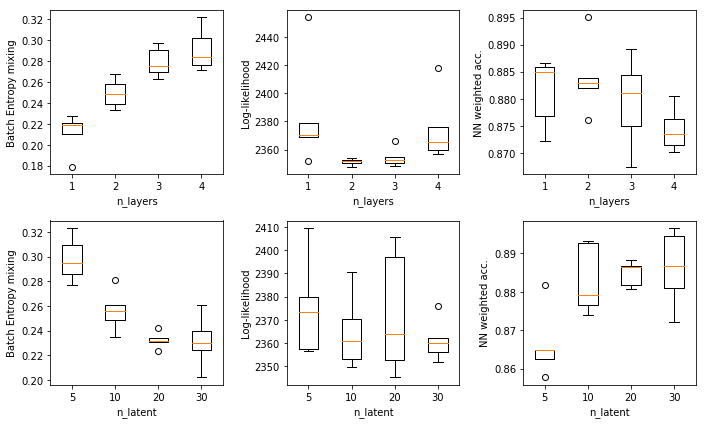

In [69]:
plt.figure(figsize=(10, 6))
name_plot = ["Average silhouette width", "NN acc.", "NN weighted acc.", "Batch Entropy mixing", "Log-likelihood"]

for i, t in enumerate([3, 4, 2]):
    plt.subplot(231 + i)
    l = []
    for j in range(4):
        l.append(list(layer_experiment[5*j:5*(j+1):, 3+t]))
    plt.boxplot(l)
    plt.xlabel("n_layers")
    plt.ylabel(name_plot[t])
    
for i, t in enumerate([3, 4, 2]):
    plt.subplot(234 + i)
    l = []
    for j in range(4):
        l.append(list(latent_experiment[5*j:5*(j+1):, 3+t]))
    plt.boxplot(l)
    plt.xticks([1, 2, 3, 4], [5, 10, 20, 30])
    plt.xlabel("n_latent")
    plt.ylabel(name_plot[t])
plt.tight_layout()
plt.savefig("figures/robustness_results.pdf", transparency=True)

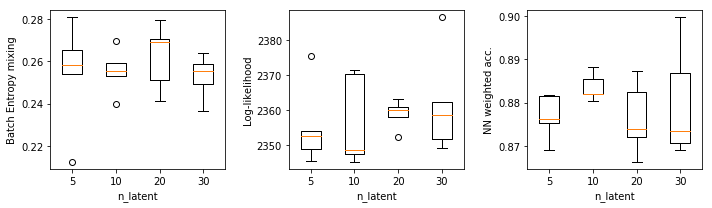

In [68]:
plt.figure(figsize=(10, 3))
name_plot = ["Average silhouette width", "NN acc.", "NN weighted acc.", "Batch Entropy mixing", "Log-likelihood"]

for i, t in enumerate([3, 4, 2]):
    plt.subplot(131 + i)
    l = []
    for j in range(4):
        l.append(list(adver_experiment[5*j:5*(j+1):, 3+t]))
    plt.boxplot(l)
    plt.xticks([1, 2, 3, 4], [5, 10, 20, 30])
    plt.xlabel("n_latent")
    plt.ylabel(name_plot[t])
plt.tight_layout()
plt.show()